In [102]:
# Data and NBA API
import pandas as pd
import numpy as np

from scipy.stats import norm, gaussian_kde, percentileofscore

pd.options.display.max_columns = None
from nba_api.stats.static import players
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.endpoints import playercareerstats

# For Shot Chart
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm
from matplotlib.patches import Circle, Rectangle, Arc, ConnectionPatch
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
from matplotlib.path import Path
from matplotlib.patches import PathPatch

sns.set_style('white')
sns.set_color_codes()

# for 3NG optimization calcs
from itertools import permutations

In [2]:
def get_player_shotchartdetail(player_name, season_id):
    """
    Parameters
    ----------
    player_name: name of the player with Capital
    season_id: ex. 2012-13
    """
    
    # player dictionary
    nba_players = players.get_players()
    player_dict = [player for player in nba_players if player['full_name'] == player_name][0]
    
    # career df
    career = playercareerstats.PlayerCareerStats(player_id=player_dict['id'])
    career_df = career.get_data_frames()[0]
    
    # team id during the season
    team_id = career_df[career_df['SEASON_ID'] == season_id]['TEAM_ID']
    
    # shotchardtdetail endpoint
    shotchartlist = shotchartdetail.ShotChartDetail(team_id=int(team_id), 
                                                   player_id=int(player_dict['id']), 
                                                   season_type_all_star='Regular Season', 
                                                   season_nullable=season_id,
                                                   context_measure_simple="FGA").get_data_frames()
    
    return shotchartlist[0], shotchartlist[1]

In [3]:
####### Function to check if point is within region #####

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import shapely.affinity

def find_court_location(x_loc, y_loc):
    """
    Takes in player shot location and outputs what region of the
    court they are on. The input must be a Point Object from
    shapely.geometry module.
    """
    
    player_shot_location = Point(x_loc,y_loc)
    
    ### Defining all possible areas of the court
    
    ## Rectangular Areas
    left_corner_three = Polygon([(-250, -47.5), (-250, 92.5), (-220, 92.5), (-220, -47.5)])
    right_corner_three = Polygon([(250, -47.5), (250, 92.5), (220, 92.5), (220, -47.5)])
    
    left_base_jump = Polygon([(-220, -47.5), (-220, 92.5), (-125, 92.5), (-125, -47.5)])
    right_base_jump = Polygon([(220, -47.5), (220, 92.5), (125, 92.5), (125, -47.5)])
    
    left_near_basket = Polygon([(-125, -47.5), (-125, 142.5), (0, 142.5), (0, -47.5)])
    right_near_basket = Polygon([(125, -47.5), (125, 142.5), (0, 142.5), (0, -47.5)])
    
    ## Left & Right Wing 2s
    circle = Point(0,0).buffer(1)
    three_circle = shapely.affinity.scale(circle, 237.5, 237.5)
    
    #making two polygons that contain the area that I want. 
    #If point is inside polygon area and circle then it is in long 2 area
    left_two_polygon = Polygon([(-250, 250), (-250, 92.5), (-125, 92.5), (-125, 250)])
    right_two_polygon = Polygon([(250, 250), (250, 92.5), (125, 92.5), (125, 250)])
     
    ## Left & Right Above FT 2s
    left_two_above_FT = Polygon([(-125, 250), (-125, 142.5), (0, 142.5), (0, 250)])
    right_two_above_FT = Polygon([(125, 250), (125, 142.5), (0, 142.5), (0, 250)])
    
    ## Above 3 point line
    big_circle = shapely.affinity.scale(circle, 287.5, 287.5)
    
    left_three_polygon = Polygon([(-250,300), (-250,0), (-125, 0), (-125, 300)])
    right_three_polygon = Polygon([(250,300), (250,0), (125, 0), (125, 300)])
    
    left_mid_three_polygon = Polygon([(-125,300), (-125,0), (0, 0), (0, 300)])
    right_mid_three_polygon = Polygon([(125,300), (125,0), (0, 0), (0, 300)])
    
    ## Dealing with Restricted Zone
    # Restricted zone below hoop (0,0)
    #left_restricted_line = Rectangle((-40, -47.5), 0, 47.5, linewidth=lw, color="red")
    restrict_below_hoop = Polygon([(-40,-47.5), (-40,0), (40, 0), (40, -47.5)])
    restrict_above_hoop = Polygon([(-40,0), (-40,40), (40, 40), (40, 0)])
    restrict_circle = shapely.affinity.scale(circle, 40, 40)
    
    if left_corner_three.contains(player_shot_location):
        return '3 pointer Left Corner'
    
    elif right_corner_three.contains(player_shot_location):
        return '3 pointer Right Corner'
        
    elif left_base_jump.contains(player_shot_location):
        return '2 pointer Left Baseline'
    
    elif right_base_jump.contains(player_shot_location):
        return '2 pointer Right Baseline'
        
    ##################### Restricted Zone ##################
    elif restrict_below_hoop.contains(player_shot_location):
        return 'Restricted Area'
        
    elif left_near_basket.contains(player_shot_location) & restrict_above_hoop.contains(player_shot_location) & restrict_circle.contains(player_shot_location):
        return 'Restricted Area'
        
    elif right_near_basket.contains(player_shot_location) & restrict_above_hoop.contains(player_shot_location) & restrict_circle.contains(player_shot_location):
        return 'Restricted Area'
        
    elif right_near_basket.contains(player_shot_location):
        return '2 pointer Left near basket'
        
    elif left_near_basket.contains(player_shot_location):
        return '2 pointer Right near basket'
    
    ######################################################
    elif three_circle.contains(player_shot_location) & left_two_polygon.contains(player_shot_location):
        return '2 pointer Left wing'
        
    elif three_circle.contains(player_shot_location) & right_two_polygon.contains(player_shot_location):
        return '2 pointer Right wing'
        
    elif three_circle.contains(player_shot_location) & left_two_above_FT.contains(player_shot_location):
        return '2 pointer Left above FT'
        
    elif three_circle.contains(player_shot_location) & right_two_above_FT.contains(player_shot_location):
        return '2 pointer Right above FT'
        
    elif big_circle.contains(player_shot_location) & left_three_polygon.contains(player_shot_location):
        return '3 pointer Left'
        
    elif big_circle.contains(player_shot_location) & right_three_polygon.contains(player_shot_location):
        return '3 pointer Right'
        
    elif big_circle.contains(player_shot_location) & left_mid_three_polygon.contains(player_shot_location):
        return '3 pointer Middle'
    
    elif big_circle.contains(player_shot_location) & right_mid_three_polygon.contains(player_shot_location):
        return '3 pointer Middle'       
    else:
        return 'Out of bounds'

In [106]:
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                         fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color="red")

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color="red")
    
    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    
################# Below this line is my new code #######################
    
    #5 feet behind 3 point line
    four_arc = Arc((0, 0), 575, 575, theta1=22, theta2=158, linewidth=lw, color='red')
    
    corner_three_zone_a = Rectangle((-250, 92.5), 30, 0, linewidth=lw, color="red")
    corner_three_zone_b = Rectangle((220, 92.5), 30, 0, linewidth=lw, color="red")
    #low_left_zone = Rectangle((-125, -47.5), 125, 190, linewidth=lw, color="red", fill=False)
    #low_right_zone = Rectangle((0, -47.5), 125, 190, linewidth=lw, color="red", fill=False)
    baseline_jump_left = Rectangle((-220,-47.5), 95, 140, linewidth=lw, color="red", fill=False)
    baseline_jump_right = Rectangle((125,-47.5), 95, 140, linewidth=lw, color="red", fill=False)
    
    # Drawing 3 lines that will make divisions in mid range & 3-pointer territories
    left_line = Rectangle((-125, 92.5), 0, 167, linewidth=lw, color="red")
    right_line = Rectangle((125, 92.5), 0, 167, linewidth=lw, color="red")
    #middle_line = Rectangle((0, 40), 0, 247.5, linewidth=lw, color="red")
    
    #adding line at FT that connects zones
    ft_zone_line = Rectangle((-125, 142.5), 250, 0, linewidth=lw, color="red")
    
    #adding two lines that connect restricted zones
    left_restricted_line = Rectangle((-40, -47.5), 0, 47.5, linewidth=lw, color="red")
    right_restricted_line = Rectangle((40, -47.5), 0, 47.5, linewidth=lw, color="red")
    
################# Above this line is my new code #######################

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, inner_box, outer_box,top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc,center_outer_arc,
                      center_inner_arc, four_arc, corner_three_zone_a, corner_three_zone_b,
                      baseline_jump_left, baseline_jump_right,
                     left_line, right_line, 
                      #middle_line, 
                      ft_zone_line,
                     left_restricted_line, right_restricted_line]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

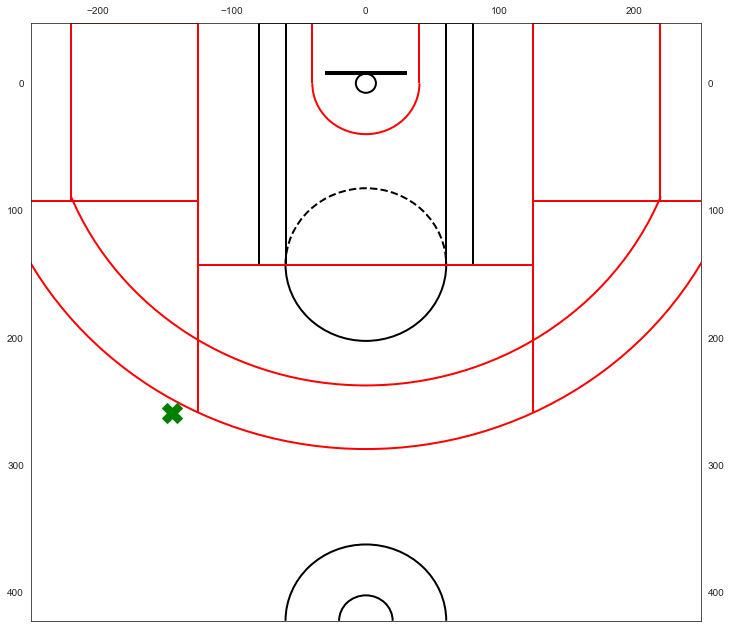

In [115]:
def visualize_shot(x,y):
    
    find_court_location(x,y)
    
    plt.figure(figsize=(12,11))

    draw_court()
    
    # Adjust plot limits to just fit in half court
    plt.xlim(-250,250)
    
    # Descending values along th y axis from bottom to top
    # in order to place the hoop by the top of plot
    plt.ylim(422.5, -47.5)
    
    # get rid of axis tick labels
    plt.tick_params(labeltop=True, labelleft=True, labelbottom=False, labelright=True)
    plt.plot(x,y, marker='X', markersize=20, color = 'green')
    plt.show()
    
visualize_shot(-145,259)

In [6]:
player_dict = {'Damian Lillard': '2019-20', 'Joel Embiid': '2019-20', 'Ben Simmons': '2019-20'}



def extract_players_API(dict_of_player_and_season):
    '''
    This function takes in a dictionary of players & years and outputs a dictionary of
    player name as the key & their pandas df as the value. This means that we can now
    build out the whole project directly from the API!!!
    '''
    
    dict_of_players_pd_df = {}
    
    for player in dict_of_player_and_season.keys():
        player_shot_chart_df, league_avg = get_player_shotchartdetail(player, dict_of_player_and_season[player])
        #dict_of_players_pd_df[player] = player_shot_chart_df
        
        new_shot_location = []

        for i in range(len(player_shot_chart_df)):
            new_shot_location.append(find_court_location(player_shot_chart_df.LOC_X[i], player_shot_chart_df.LOC_Y[i]))
    
        player_shot_chart_df['new_shot_location'] = new_shot_location
        
        dict_of_players_pd_df[player] = player_shot_chart_df
        
    return dict_of_players_pd_df

In [7]:
dame_joel_simmons = extract_players_API(player_dict)

In [8]:
dame_joel_simmons['Joel Embiid']

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,new_shot_location
0,Shot Chart Detail,0021900008,11,203954,Joel Embiid,1610612755,Philadelphia 76ers,1,11,26,Made Shot,Alley Oop Layup shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,-17,5,1,1,20191023,PHI,BOS,Restricted Area
1,Shot Chart Detail,0021900008,16,203954,Joel Embiid,1610612755,Philadelphia 76ers,1,10,55,Missed Shot,Fadeaway Jump Shot,2PT Field Goal,Mid-Range,Center(C),8-16 ft.,15,14,157,1,0,20191023,PHI,BOS,2 pointer Right above FT
2,Shot Chart Detail,0021900008,19,203954,Joel Embiid,1610612755,Philadelphia 76ers,1,10,34,Missed Shot,Turnaround Fadeaway shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,10,-106,1,1,0,20191023,PHI,BOS,2 pointer Right near basket
3,Shot Chart Detail,0021900008,150,203954,Joel Embiid,1610612755,Philadelphia 76ers,1,1,19,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,25,-25,258,1,0,20191023,PHI,BOS,3 pointer Middle
4,Shot Chart Detail,0021900008,159,203954,Joel Embiid,1610612755,Philadelphia 76ers,1,0,14,Missed Shot,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,3,25,23,1,0,20191023,PHI,BOS,Restricted Area
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,Shot Chart Detail,0021901315,164,203954,Joel Embiid,1610612755,Philadelphia 76ers,1,0,7,Missed Shot,Turnaround Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,13,-54,124,1,0,20200814,HOU,PHI,2 pointer Right near basket
797,Shot Chart Detail,0021901315,242,203954,Joel Embiid,1610612755,Philadelphia 76ers,2,7,0,Made Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,14,-146,11,1,1,20200814,HOU,PHI,2 pointer Left Baseline
798,Shot Chart Detail,0021901315,305,203954,Joel Embiid,1610612755,Philadelphia 76ers,2,0,43,Made Shot,Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,12,19,1,1,20200814,HOU,PHI,Restricted Area
799,Shot Chart Detail,0021901315,336,203954,Joel Embiid,1610612755,Philadelphia 76ers,3,9,35,Missed Shot,Layup Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,6,20,59,1,0,20200814,HOU,PHI,2 pointer Left near basket


In [9]:
dame_joel_simmons['Damian Lillard']

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,new_shot_location
0,Shot Chart Detail,0021900013,22,203081,Damian Lillard,1610612757,Portland Trail Blazers,1,10,25,Missed Shot,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,5,58,-5,1,0,20191023,POR,DEN,2 pointer Left near basket
1,Shot Chart Detail,0021900013,46,203081,Damian Lillard,1610612757,Portland Trail Blazers,1,8,42,Missed Shot,Jump Shot,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,23,-232,-9,1,0,20191023,POR,DEN,3 pointer Left Corner
2,Shot Chart Detail,0021900013,145,203081,Damian Lillard,1610612757,Portland Trail Blazers,1,2,44,Made Shot,Driving Dunk Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,-3,8,1,1,20191023,POR,DEN,Restricted Area
3,Shot Chart Detail,0021900013,295,203081,Damian Lillard,1610612757,Portland Trail Blazers,2,4,22,Missed Shot,Pullup Jump shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,24,-52,244,1,0,20191023,POR,DEN,3 pointer Middle
4,Shot Chart Detail,0021900013,305,203081,Damian Lillard,1610612757,Portland Trail Blazers,2,3,8,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,19,-105,159,1,1,20191023,POR,DEN,2 pointer Left above FT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344,Shot Chart Detail,0021901309,554,203081,Damian Lillard,1610612757,Portland Trail Blazers,4,9,32,Made Shot,Step Back Jump shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,26,-119,236,1,1,20200813,BKN,POR,3 pointer Middle
1345,Shot Chart Detail,0021901309,560,203081,Damian Lillard,1610612757,Portland Trail Blazers,4,8,31,Missed Shot,Driving Floating Bank Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,5,-46,38,1,0,20200813,BKN,POR,2 pointer Right near basket
1346,Shot Chart Detail,0021901309,581,203081,Damian Lillard,1610612757,Portland Trail Blazers,4,7,12,Made Shot,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,27,65,268,1,1,20200813,BKN,POR,3 pointer Middle
1347,Shot Chart Detail,0021901309,612,203081,Damian Lillard,1610612757,Portland Trail Blazers,4,4,34,Missed Shot,Pullup Jump shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,29,-149,249,1,0,20200813,BKN,POR,Out of bounds


In [10]:
##### 3NG ##### 
#3NG = 3P * 1.94 - 3Mi * 1.06.

test = list(dame_joel_simmons['Damian Lillard']['new_shot_location'].unique())
test

['2 pointer Left near basket',
 '3 pointer Left Corner',
 'Restricted Area',
 '3 pointer Middle',
 '2 pointer Left above FT',
 '3 pointer Right',
 'Out of bounds',
 '3 pointer Left',
 '2 pointer Right near basket',
 '2 pointer Right wing',
 '2 pointer Right Baseline',
 '2 pointer Right above FT',
 '2 pointer Left Baseline',
 '2 pointer Left wing',
 '3 pointer Right Corner']

In [11]:
three_unique = [i for i in test if i.startswith('3')]

In [12]:
print(three_unique)

['3 pointer Left Corner', '3 pointer Middle', '3 pointer Right', '3 pointer Left', '3 pointer Right Corner']


In [13]:
# make a dictionary with the keys as the unique 3 pointer and the value as a list of [made, missed]

dame_joel_simmons['Damian Lillard']['new_shot_location'] == '3 pointer Left'

0       False
1       False
2       False
3       False
4       False
        ...  
1344    False
1345    False
1346    False
1347    False
1348    False
Name: new_shot_location, Length: 1349, dtype: bool

In [14]:
three_left = dame_joel_simmons['Damian Lillard'][dame_joel_simmons['Damian Lillard']['new_shot_location'] == '3 pointer Left Corner']

#titanic[titanic["Age"] > 35]


In [15]:
### Calculate 3NG using shot_make_tracker
three_left

made_counter = 0
missed_counter = 0
shot_make_tracker = {}

for shot in three_left['SHOT_MADE_FLAG']:
    if shot == 0:
        missed_counter += 1
    else:
        made_counter += 1
        
shot_make_tracker['make'] = made_counter
shot_make_tracker['miss'] = missed_counter
  
#3NG = 3P * 1.94 - 3Mi * 1.06.

three_net_gain = (shot_make_tracker['make'] * 1.94) - (shot_make_tracker['miss'] * 1.06) 

In [16]:
print(shot_make_tracker)
print(three_net_gain)

{'make': 2, 'miss': 5}
-1.4200000000000008


In [17]:
three_middle = dame_joel_simmons['Damian Lillard'][dame_joel_simmons['Damian Lillard']['new_shot_location'] == '3 pointer Middle']

In [18]:
made_counter = 0
missed_counter = 0
shot_make_tracker = {}

for shot in three_middle['SHOT_MADE_FLAG']:
    if shot == 0:
        missed_counter += 1
    else:
        made_counter += 1
        
shot_make_tracker['make'] = made_counter
shot_make_tracker['miss'] = missed_counter
  
#3NG = 3P * 1.94 - 3Mi * 1.06.

three_net_gain = (shot_make_tracker['make'] * 1.94) - (shot_make_tracker['miss'] * 1.06)

In [19]:
print(three_net_gain)
print(shot_make_tracker)

6.280000000000001
{'make': 77, 'miss': 135}


In [20]:

#### Function for 3NG of each position on the court ###
def find_all_3NG(player_df):
    
    three_loc = ['3 pointer Left Corner', '3 pointer Middle', '3 pointer Right', 
                 '3 pointer Left',  '3 pointer Right Corner']
    
    shot_make_tracker = {}
    
    for shot_loc in three_loc:
        shot_data = player_df[player_df['new_shot_location'] == shot_loc]
        
        made_counter = 0
        missed_counter = 0
        
        for shot in shot_data['SHOT_MADE_FLAG']:
            if shot == 0:
                missed_counter += 1
            else:
                made_counter += 1
                
        #3NG = 3P * 1.94 - 3Mi * 1.06. 
        three_net_gain = round(made_counter*1.94 - missed_counter*1.06 , 2)
        shot_make_tracker[shot_loc] = [[made_counter, missed_counter], three_net_gain]
        
    return shot_make_tracker

In [21]:
lillard_df = dame_joel_simmons['Damian Lillard']
find_all_3NG(lillard_df)

{'3 pointer Left Corner': [[2, 5], -1.42],
 '3 pointer Middle': [[77, 135], 6.28],
 '3 pointer Right': [[44, 67], 14.34],
 '3 pointer Left': [[48, 68], 21.04],
 '3 pointer Right Corner': [[8, 9], 5.98]}

In [22]:
# have to remake this function so it takes in # of games played by player
def all_players_3NG(all_players_dict):
    
    player_3NG_dict = {}
    
    for player in all_players_dict.keys():
        player_3NG_dict[player] = find_all_3NG(all_players_dict[player])
    
    return player_3NG_dict

In [23]:
all_players_3NG(dame_joel_simmons)

{'Damian Lillard': {'3 pointer Left Corner': [[2, 5], -1.42],
  '3 pointer Middle': [[77, 135], 6.28],
  '3 pointer Right': [[44, 67], 14.34],
  '3 pointer Left': [[48, 68], 21.04],
  '3 pointer Right Corner': [[8, 9], 5.98]},
 'Joel Embiid': {'3 pointer Left Corner': [[2, 1], 2.82],
  '3 pointer Middle': [[35, 78], -14.78],
  '3 pointer Right': [[3, 9], -3.72],
  '3 pointer Left': [[15, 11], 17.44],
  '3 pointer Right Corner': [[0, 5], -5.3]},
 'Ben Simmons': {'3 pointer Left Corner': [[1, 1], 0.88],
  '3 pointer Middle': [[0, 1], -1.06],
  '3 pointer Right': [[0, 0], 0.0],
  '3 pointer Left': [[0, 0], 0.0],
  '3 pointer Right Corner': [[1, 0], 1.94]}}

In [24]:
######### Downloading 5 great shooters ###########
great_shooters_dict = {'Stephen Curry': '2020-21', 'Buddy Hield': '2020-21', 'Duncan Robinson': '2020-21',
                      'Damian Lillard': '2020-21', 'Joe Harris': '2020-21'}
great_shooters = extract_players_API(great_shooters_dict)

In [25]:
great_shooters['Damian Lillard']

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,new_shot_location
0,Shot Chart Detail,0022000020,26,203081,Damian Lillard,1610612757,Portland Trail Blazers,1,10,49,Missed Shot,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,11,-119,15,1,0,20201223,POR,UTA,2 pointer Right near basket
1,Shot Chart Detail,0022000020,44,203081,Damian Lillard,1610612757,Portland Trail Blazers,1,8,35,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,28,-188,214,1,0,20201223,POR,UTA,3 pointer Left
2,Shot Chart Detail,0022000020,92,203081,Damian Lillard,1610612757,Portland Trail Blazers,1,5,21,Missed Shot,Alley Oop Layup shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,-11,5,1,0,20201223,POR,UTA,Restricted Area
3,Shot Chart Detail,0022000020,231,203081,Damian Lillard,1610612757,Portland Trail Blazers,2,6,16,Missed Shot,Pullup Jump shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,29,-81,283,1,0,20201223,POR,UTA,Out of bounds
4,Shot Chart Detail,0022000020,289,203081,Damian Lillard,1610612757,Portland Trail Blazers,2,1,18,Missed Shot,Pullup Jump shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,27,89,261,1,0,20201223,POR,UTA,3 pointer Middle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329,Shot Chart Detail,0022001076,397,203081,Damian Lillard,1610612757,Portland Trail Blazers,3,5,2,Made Shot,Pullup Jump shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,31,29,309,1,1,20210516,POR,DEN,Out of bounds
1330,Shot Chart Detail,0022001076,400,203081,Damian Lillard,1610612757,Portland Trail Blazers,3,4,29,Made Shot,Step Back Jump shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,27,-18,273,1,1,20210516,POR,DEN,3 pointer Middle
1331,Shot Chart Detail,0022001076,429,203081,Damian Lillard,1610612757,Portland Trail Blazers,3,2,8,Missed Shot,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,1,5,1,0,20210516,POR,DEN,Restricted Area
1332,Shot Chart Detail,0022001076,437,203081,Damian Lillard,1610612757,Portland Trail Blazers,3,1,42,Made Shot,Turnaround Fadeaway shot,2PT Field Goal,Mid-Range,Center(C),8-16 ft.,15,-32,155,1,1,20210516,POR,DEN,2 pointer Left above FT


In [26]:
##### Making function in order to find ideal placement of 5 shooters ######
three_ng_dict = all_players_3NG(great_shooters)

In [27]:
three_ng_dict['Stephen Curry']['3 pointer Left Corner'][1]

-9.92

In [28]:
steph_3NG = three_ng_dict['Stephen Curry']
steph_3NG

{'3 pointer Left Corner': [[8, 24], -9.92],
 '3 pointer Middle': [[95, 122], 54.98],
 '3 pointer Right': [[74, 89], 49.22],
 '3 pointer Left': [[69, 96], 32.1],
 '3 pointer Right Corner': [[15, 15], 13.2]}

In [29]:
# return a list of lists of sorted 3NG & shot location
def sort_3NG(dict_3NG):
    list_of_3NG = []
    
    for shot_loc in dict_3NG.keys():
        list_of_3NG.append([dict_3NG[shot_loc][1],shot_loc])
        
    return sorted(list_of_3NG, reverse = True)

In [30]:
# takes in three_ng_dict
def sort_all_players_3NG(dict_of_3NG):
    sorted_all_players_3NG = {}
    
    for player in dict_of_3NG.keys():
        sorted_all_players_3NG[player] = sort_3NG(dict_of_3NG[player])
        
    return sorted_all_players_3NG

In [31]:
three_ng_dict

{'Stephen Curry': {'3 pointer Left Corner': [[8, 24], -9.92],
  '3 pointer Middle': [[95, 122], 54.98],
  '3 pointer Right': [[74, 89], 49.22],
  '3 pointer Left': [[69, 96], 32.1],
  '3 pointer Right Corner': [[15, 15], 13.2]},
 'Buddy Hield': {'3 pointer Left Corner': [[31, 35], 23.04],
  '3 pointer Middle': [[96, 161], 15.58],
  '3 pointer Right': [[45, 77], 5.68],
  '3 pointer Left': [[75, 123], 15.12],
  '3 pointer Right Corner': [[19, 25], 10.36]},
 'Duncan Robinson': {'3 pointer Left Corner': [[16, 35], -6.06],
  '3 pointer Middle': [[84, 105], 51.66],
  '3 pointer Right': [[60, 86], 25.24],
  '3 pointer Left': [[48, 79], 9.38],
  '3 pointer Right Corner': [[31, 45], 12.44]},
 'Damian Lillard': {'3 pointer Left Corner': [[4, 8], -0.72],
  '3 pointer Middle': [[94, 121], 54.1],
  '3 pointer Right': [[53, 67], 31.8],
  '3 pointer Left': [[57, 77], 28.96],
  '3 pointer Right Corner': [[2, 15], -12.02]},
 'Joe Harris': {'3 pointer Left Corner': [[17, 11], 21.32],
  '3 pointer Middle

In [118]:
def create_np_array_of_3NG(dict_of_3NG):
    index_1 = []
    index_2 = []
    index_3 = []
    index_4 = []
    index_5 = []

    for player in dict_of_3NG.keys():
        for shot_loc in dict_of_3NG[player]:
            if shot_loc == '3 pointer Left Corner':
                index_1.append(dict_of_3NG[player][shot_loc][1])
            if shot_loc == '3 pointer Middle':
                index_2.append(dict_of_3NG[player][shot_loc][1])
            if shot_loc == '3 pointer Right':
                index_3.append(dict_of_3NG[player][shot_loc][1])
            if shot_loc == '3 pointer Left':
                index_4.append(dict_of_3NG[player][shot_loc][1])
            if shot_loc == '3 pointer Right Corner':
                index_5.append(dict_of_3NG[player][shot_loc][1])
                
    return np.array([index_1, index_2, index_3, index_4, index_5])

In [119]:
create_np_array_of_3NG(three_ng_dict)

array([[ -9.92,  23.04,  -6.06,  -0.72,  21.32],
       [ 54.98,  15.58,  51.66,  54.1 ,  43.76],
       [ 49.22,   5.68,  25.24,  31.8 ,  43.3 ],
       [ 32.1 ,  15.12,   9.38,  28.96,  40.14],
       [ 13.2 ,  10.36,  12.44, -12.02,  15.8 ]])

In [100]:
######## Function that finds the greatest sum of 3NG for 5 players #######
from itertools import permutations
import numpy as np

def optimized_player_location(dict_of_3NG):
    np_array = create_np_array_of_3NG(dict_of_3NG)
    optimized_shooting_dict = {}
    
    #finds optimized list, index corresponds to player, index value corresponds to row
    best_perm = None
    best_sum = -np.inf
    for perm in permutations(range(5)):
        s = sum([arr[perm[i],i] for i in range(5)])
        if s > best_sum:
            best_sum = s
            best_perm = perm
    
    # making list of lists of optimized player column # and player shot location row #
    list_of_players_best_shot_locs = []
    for index, value in enumerate(list(best_perm)):
        list_of_players_best_shot_locs.append([index, value])
    
    #converting dict_of_3NG to pandas dataframe
    df = pd.DataFrame(dict_of_3NG)
    
    # appending to optimized_shooting_dict
    for values in list_of_players_best_shot_locs:
        optimized_shooting_dict[df.columns[values[0]]] = df.index[values[1]]
        
    return optimized_shooting_dict    

In [101]:
optimized_player_location(three_ng_dict)

{'Stephen Curry': '3 pointer Right',
 'Buddy Hield': '3 pointer Left Corner',
 'Duncan Robinson': '3 pointer Right Corner',
 'Damian Lillard': '3 pointer Middle',
 'Joe Harris': '3 pointer Left'}